In [5]:
# imports
import os
from PIL import Image
from torchvision import transforms
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
import shutil
import random

# Data Balancing

In [23]:
def balance_datasets(src_dirs, dest_dir):
    # Crea la cartella di destinazione se non esiste
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Trova il numero minimo di immagini tra tutte le cartelle
    min_images = min([len(os.listdir(src)) for src in src_dirs if os.path.isdir(src)])
    print(f"Numero minimo di immagini per cartella: {min_images}")
    
    # Per ogni cartella di origine, copiamo un numero minimo di immagini
    for src_dir in src_dirs:
        # Verifica che la cartella sorgente esista ed è una directory
        if not os.path.isdir(src_dir):
            print(f"Attenzione: la cartella {src_dir} non è valida.")
            continue

        # Crea la cartella di destinazione per ciascuna classe
        class_name = os.path.basename(src_dir.rstrip('/'))
        dest_class_dir = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_class_dir):
            os.makedirs(dest_class_dir)
        
        # Ottieni la lista di tutte le immagini nella cartella
        images = [img for img in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, img))]
        print(f"Classe {class_name}: {len(images)} immagini disponibili.")
        
        # Verifica se ci sono abbastanza immagini
        if len(images) < min_images:
            print(f"Classe {class_name} ha meno immagini di {min_images}. Procedo comunque con {len(images)} immagini.")
            selected_images = images  # Usa tutte le immagini disponibili
        else:
            selected_images = random.sample(images, min_images)  # Seleziona un numero di immagini pari al minimo
        
        # Copia le immagini selezionate nella cartella di destinazione
        for img in selected_images:
            src_img_path = os.path.join(src_dir, img)
            dest_img_path = os.path.join(dest_class_dir, img)
            shutil.copy(src_img_path, dest_img_path)
        print(f"Copiate {len(selected_images)} immagini in {dest_class_dir}.")

# Esempio di uso
src_dirs = ["./train/0", "./train/1", "./train/2", "./train/3", "./train/4"]
dest_dir = "./train_balanced"
balance_datasets(src_dirs, dest_dir)


Numero minimo di immagini per cartella: 369
Classe 0: 1000 immagini disponibili.
Copiate 369 immagini in ./train_balanced\0.
Classe 1: 1500 immagini disponibili.
Copiate 369 immagini in ./train_balanced\1.
Classe 2: 1500 immagini disponibili.
Copiate 369 immagini in ./train_balanced\2.
Classe 3: 2000 immagini disponibili.
Copiate 369 immagini in ./train_balanced\3.
Classe 4: 369 immagini disponibili.
Copiate 369 immagini in ./train_balanced\4.


In [24]:
[len(os.listdir(os.path.join('train_balanced/0'))),
 len(os.listdir(os.path.join('train_balanced/1'))),
 len(os.listdir(os.path.join('train_balanced/2'))),
 len(os.listdir(os.path.join('train_balanced/3'))),
 len(os.listdir(os.path.join('train_balanced/4')))]

[369, 369, 369, 369, 369]

# Data Augmentation

## Horizontal Flip

### Implementation

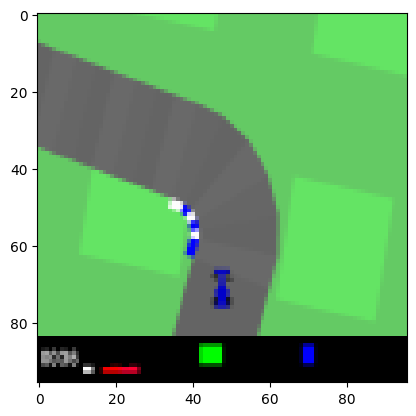

In [2]:
test_img_path = os.path.join('./temp.png') # img taken from steer-left class
img = cv2.imread(test_img_path)

plt.imshow(img)
plt.show()

We want to flip the image in horizontal, but not the panel. And since flipping the image leads to a different class (right to left and viceversa) the green sign need to be adjusted.

So, now we crop the green sign and flip on the opposite part.

Position of the green sign:
48 pixels : the center
18 pixels : lenght for steer 

In [7]:
def crop_panel(image):
    img = image.copy()
    # Ritaglia la parte superiore (macchina) e inferiore (pannello)
    
    panel_crop = img[84:96, 0:96]  # Prendi i pixel da 84 a 96 lungo l'altezza (H)

    return panel_crop

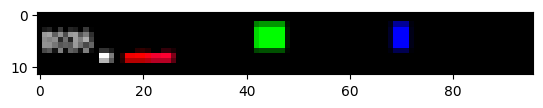

In [4]:
panel = crop_panel(img)

plt.imshow(panel)
plt.show()

In [3]:
def adjust_left_signal(panel):

    updated_panel = panel.copy()

    img_height, img_width, _ = panel.shape
    center = img_width // 2

    sign_width = 18
    sign_top_left = [center - sign_width, img_height - 10]
    sign_bot_right = [center, img_height - 4]


    # Crop the green sign
    green_sign = panel[sign_top_left[1]:sign_bot_right[1], sign_top_left[0]:sign_bot_right[0]]

    flipped_green_sign = green_sign[:, ::-1]
    
    # Calcola la nuova posizione per traslare di 18 pixel verso destra
    new_sign_top_left = [sign_top_left[0] + sign_width, sign_top_left[1]]
    new_sign_bot_right = [sign_bot_right[0] + sign_width, sign_bot_right[1]]

    # Rimpiazza la porzione originale con il segnale flippato
    updated_panel[sign_top_left[1]:sign_bot_right[1], sign_top_left[0]:sign_bot_right[0]] = 0
    updated_panel[new_sign_top_left[1]:new_sign_bot_right[1], new_sign_top_left[0]:new_sign_bot_right[0]] = flipped_green_sign
    
    return updated_panel

In [8]:
def adjust_right_signal(panel):

    updated_panel = panel.copy()

    img_height, img_width, _ = panel.shape
    center = img_width // 2

    sign_width = 18
    sign_top_left = [center, img_height - 10]
    sign_bot_right = [center + sign_width, img_height - 4]


    # Crop the green sign
    green_sign = panel[sign_top_left[1]:sign_bot_right[1], sign_top_left[0]:sign_bot_right[0]]

    flipped_green_sign = green_sign[:, ::-1]
    
    # Calcola la nuova posizione per traslare di 18 pixel verso destra
    new_sign_top_left = [sign_top_left[0] - sign_width, sign_top_left[1]]
    new_sign_bot_right = [sign_bot_right[0] - sign_width, sign_bot_right[1]]

    # Rimpiazza la porzione originale con il segnale flippato
    updated_panel[sign_top_left[1]:sign_bot_right[1], sign_top_left[0]:sign_bot_right[0]] = 0
    updated_panel[new_sign_top_left[1]:new_sign_bot_right[1], new_sign_top_left[0]:new_sign_bot_right[0]] = flipped_green_sign
    
    return updated_panel
    

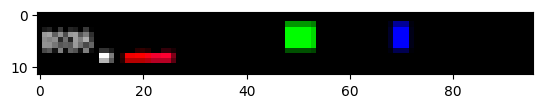

In [10]:
plt.imshow(adjust_left_signal(panel=panel))
plt.show()

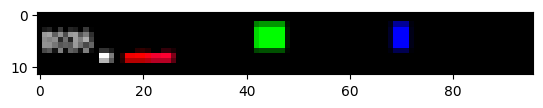

In [103]:
plt.imshow(crop_panel(img))
plt.show()

Let us now flip the entire image and adjust the panel

In [4]:
def flip_right(image):
    img = image.copy()

    panel = crop_panel(img)
    adjusted_panel = adjust_left_signal(panel)

    # Flippa l'intera immagine
    flipped_img = img[:, ::-1]

    # Inserisci il pannello corretto nella nuova immagine
    flipped_img[84:96, 0:96] = adjusted_panel

    return flipped_img

In [5]:
def flip_left(image):
    img = image.copy()

    panel = crop_panel(img)
    adjusted_panel = adjust_right_signal(panel)

    # Flippa l'intera immagine
    flipped_img = img[:, ::-1]

    # Inserisci il pannello corretto nella nuova immagine
    flipped_img[84:96, 0:96] = adjusted_panel

    return flipped_img

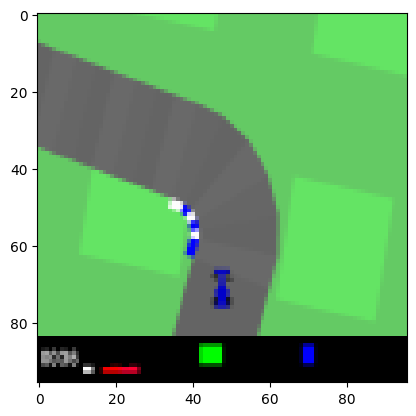

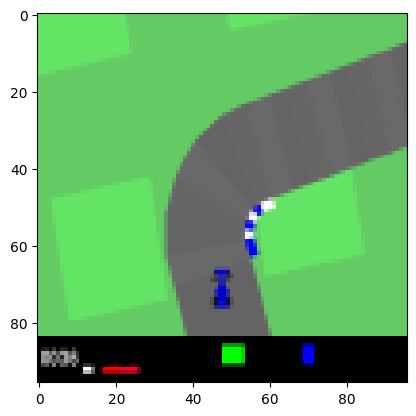

In [25]:
# original
plt.imshow(img)
plt.show()

#flipped
plt.imshow(flip_right(img))
plt.show()

### Dataset creation

In [9]:
from PIL import Image

def create_flipped_steer_dataset(input_dir, output_dir, side):
    """Crea un nuovo dataset con immagini flippate e pannelli regolati."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if not filename.endswith((".jpg", ".png")):
            continue

        # Carica l'immagine
        img_path = os.path.join(input_dir, filename)
        img = np.array(Image.open(img_path))

        flipped_img = None
        if side == 'LEFT':
            flipped_img = flip_left(img)
        elif side == 'RIGHT':
            flipped_img = flip_right(img)
        else:
            print("Check the side!")
            return

        # Salva il risultato
        output_path = os.path.join(output_dir, filename)
        Image.fromarray(img).save(output_path)
        output_path = os.path.join(output_dir, "aug_" + filename)
        Image.fromarray(flipped_img.astype('uint8')).save(output_path)
        
        #print(f"Processed and saved: {filename}")

In [26]:
create_flipped_steer_dataset('./train_balanced/2', './train_balanced_augmented/1', 'RIGHT')

In [27]:
create_flipped_steer_dataset('./train_balanced/1', './train_balanced_augmented/2', 'LEFT')

#### Flipped not steered

In [28]:
def flip_no_steer(image):
    img = image.copy()

    panel = crop_panel(img)

    # Flippa l'intera immagine
    flipped_img = img[:, ::-1]

    # Inserisci il pannello corretto nella nuova immagine
    flipped_img[84:96, 0:96] = panel

    return flipped_img

In [29]:
def create_flipped_dataset(input_dir, output_dir):
    """Crea un nuovo dataset con immagini flippate e pannelli regolati."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if not filename.endswith((".jpg", ".png")):
            continue

        # Carica l'immagine
        img_path = os.path.join(input_dir, filename)
        img = np.array(Image.open(img_path))

        flipped_img = flip_no_steer(img)

        # Salva il risultato
        output_path = os.path.join(output_dir, filename)
        Image.fromarray(img).save(output_path)
        output_path = os.path.join(output_dir, "aug_" + filename)
        Image.fromarray(flipped_img.astype('uint8')).save(output_path)
        
        #print(f"Processed and saved: {filename}")

In [30]:
create_flipped_dataset('./train_balanced/0', './train_balanced_augmented/0')

In [31]:
create_flipped_dataset('./train_balanced/3', './train_balanced_augmented/3')

In [32]:
create_flipped_dataset('./train_balanced/4', './train_balanced_augmented/4')

In [33]:
[len(os.listdir(os.path.join('train_balanced_augmented/0'))),
 len(os.listdir(os.path.join('train_balanced_augmented/1'))),
 len(os.listdir(os.path.join('train_balanced_augmented/2'))),
 len(os.listdir(os.path.join('train_balanced_augmented/3'))),
 len(os.listdir(os.path.join('train_balanced_augmented/4')))]

[738, 738, 738, 738, 738]

## Mark edges

In [1]:
def preprocess_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Creare la directory di output
    
    i = 0
    for filename in os.listdir(input_dir):
        
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            filepath = os.path.join(input_dir, filename)
            
            # Leggere l'immagine
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            
            # Applica il filtro Sobel per evidenziare le linee
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Bordi verticali
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Bordi orizzontali
            sobel_combined = cv2.magnitude(sobelx, sobely)      # Combina i bordi
            
            # Normalizza il risultato per salvarlo
            sobel_combined = np.uint8(cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX))
            
            # Salva l'immagine preprocessata
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, sobel_combined)
            i += 1

            # Facoltativo: mostra una preview
            #plt.imshow(sobel_combined, cmap='gray')
            #plt.title(f"Preprocessed: {filename}")
            #plt.show()

In [2]:
def preprocess_images_top_only(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Creare la directory di output
    
    for filename in os.listdir(input_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            filepath = os.path.join(input_dir, filename)
            
            # Leggi l'immagine
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            height, width = img.shape
            
            # Ritaglia il pannello inferiore e copia
            
            panel = crop_panel(img)
            top_img = img[:height - panel.shape[0], :]  # Parte superiore
            
            # Applica il filtro Sobel solo alla parte superiore
            sobelx = cv2.Sobel(top_img, cv2.CV_64F, 1, 0, ksize=3)  # Bordi verticali
            sobely = cv2.Sobel(top_img, cv2.CV_64F, 0, 1, ksize=3)  # Bordi orizzontali
            sobel_combined = cv2.magnitude(sobelx, sobely)          # Combina i bordi
            
            # Normalizza la parte superiore
            sobel_combined = np.uint8(cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX))
            
            # Ricombina il pannello originale
            combined_image = np.vstack((sobel_combined, panel))
            
            # Salva l'immagine finale
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, combined_image)

In [21]:
# Cartelle del dataset
input_dir = 'train_balanced/4'
output_dir = 'train_balanced_edges/4'

In [22]:
# Preprocessing
preprocess_images_top_only(input_dir, output_dir)

In [23]:
print(len(os.listdir(os.path.join(input_dir))))
len(os.listdir(os.path.join(output_dir)))

369


369

# Remove augmented files

In [ ]:
len(os.listdir(os.path.join('train/edges/0')))

NameError: name 'os' is not defined

In [ ]:
for filename in os.listdir('train/edges/0'):
    if filename.startswith('aug'):
        os.remove(os.path.join('train/edges/0', filename))